# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


После вывода метода `.info()`  видим, что в двух столбцах: *days_employed*  и *total_income* есть отсутствующие значения. В остальном типы данных логически соответствуют столбцам. Стоит посмотреть сам датасет. 

In [2]:
df.head(30)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


**Вывод**

- В датасете встречаются пропущенные значения в различных стобцах, что может негативно повлиять на репрезентативность выборки;
- В датасете в столбце education используются как заглавные,так и прописные методы записи;
- Названия столбцов записаны правильно,в редактуре не нуждаются.
- В столбце *days_employed* встречаются отрицательные и непропорционально большие значения.



## Шаг 2. Предобработка данных

### Обработка пропусков

Для начала определим количество пропусков в датафрейме:

In [3]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Видно, что количество пропусков в стобцах  *days_employed* и *total_income* совпадают. Рассмотрим датафрейм с пропущенными значениями используя фильтрацию.

In [4]:
df[df['days_employed'].isna()].head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


#### Учёт трудового стажа

В исследовании нет задач, требующих учёта трудового стажа. Но мы не знаем, пригодятся ли они при дальнейших исследованиях, так что оставим их и данные в  столбце 'days_employed' заполним по медиане. Остальные данные по каждому из клиентов являются существенными. Так же в глаза бросаются очень большие либо отрицательные значения трудового стажа, попробуем разобраться,в чём дело. Можно пропробовать посмотреть на графике распределение значений по группам

In [3]:
#сначала посмотрим уникальные значения для столбца 'income_type'
income_type = df['income_type'].unique()
print(income_type)

#Зададим параметры для графика
sns.set(rc={'figure.figsize':(15, 5)})


['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']


Таким образом хорошей идеей будет использовать именно столбец с типом занятости для группировки и анализа.

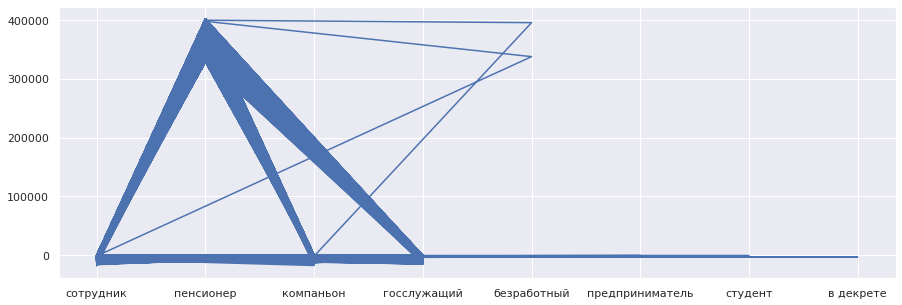

In [6]:
#построим график для групп по типу занятости
#sns.barplot(x = 'income_type',y = 'days_employed', data = df).set(xlabel = 'Тип занятости', ylabel='Стаж в днях');
plt.plot(df['income_type'], df['days_employed'])
#plt.legend(income_type, ncol=2, loc='upper left');

Видим, что значения очень сильно разнятся для пенсионеров, безработных и остальных. 

Скорее всего это систематическая ошибка,связанная с неправильным заполнением форм.
Данные по стажу в заявки на кредит вносятся не в днях, а датами, например: 20/12/2011.

При заполении могла возникуть ошибка с разделителями значений и дефис между датой приема и датой увольнения мог быть считан как знак вычитания 00.01.2011 - 30.12.2020 . Из-за чего появились числа совершенно различных порядков и отрицательные числа. Попробуем привести всё это к адекватному виду. 

Для начала заменим отсутствующие значения на нули:

In [7]:
df['days_employed'] = df['days_employed'].fillna(0)

Для замены данных  используем метод `abs()`

In [8]:
df['days_employed'] = df['days_employed'].abs()
#df.head(15)

In [9]:
#Используем медианы значений по группам
employee_days = df[df['income_type'] == 'сотрудник']['days_employed'].median()
companion_days = df[df['income_type'] == 'компаньон']['days_employed'].median()
pensioner_days = df[df['income_type'] == 'пенсионер']['days_employed'].median()
civil_days = df[df['income_type'] == 'госслужащий']['days_employed'].median()
buisnessman_days = df[df['income_type'] == 'предприниматель']['days_employed'].median()

#Осуществим замены
df.loc[(df['income_type'] == 'сотрудник') & (df['days_employed'] == 0),'days_employed'] = employee_days
df.loc[(df['income_type'] == 'компаньон') & (df['days_employed'] == 0),'days_employed'] = companion_days
df.loc[(df['income_type'] == 'пенсионер') & (df['days_employed'] == 0),'days_employed'] = pensioner_days
df.loc[(df['income_type'] == 'госслужащий') & (df['days_employed'] == 0),'total_income'] = civil_days
df.loc[(df['income_type'] == 'предприниматель') & (df['days_employed'] == 0),'total_income'] = buisnessman_days


#### Доходы клиентов

Видно, что отстутствующие значения присутствуют также в столбце *'total_incomе'*. Этот столбец является важным для дальнейших исследований. Для этого сгруппируем значения по типу занятости и заменим значения *NaN* в этом столбце по медианной зарплате для каждой из групп для более точной модели.
К тому же, все значения пропуски в столбцах *'total_income'* и *'days_employed'* встречаются в одинаковых строках, что говорит об ошибке при выгрузке.

In [10]:
df[df['total_income'].isna() == True].groupby('income_type')['income_type'].count()#.sort_values(ascending = False)

income_type
компаньон     508
пенсионер     413
сотрудник    1105
Name: income_type, dtype: int64

 Из полученных ранее данных так же используем группы,в которых требуется найти медианное значение (репрезентативнее, чем среднее, когда речь идёт о зарплатах) дохода для заполнения пропусков в данных.
Создадим переменные с медианными значениями по группам.

In [11]:
# Заменим отстутствующие занчения на 0
df['total_income'] = df['total_income'].fillna(0)

#Создадим переменные с медианами зарплат по группам
employee_income = df[df['income_type'] == 'сотрудник']['total_income'].median()
companion_income = df[df['income_type'] == 'компаньон']['total_income'].median()
pensioner_income = df[df['income_type'] == 'пенсионер']['total_income'].median()
civil_income = df[df['income_type'] == 'госслужащий']['total_income'].median()
buisnessman_income = df[df['income_type'] == 'предприниматель']['total_income'].median()


# Заменим пропуски в значениях
df.loc[(df['income_type'] == 'сотрудник') & (df['total_income'] == 0),'total_income'] = employee_income
df.loc[(df['income_type'] == 'компаньон') & (df['total_income'] == 0),'total_income'] = companion_income
df.loc[(df['income_type'] == 'пенсионер') & (df['total_income'] == 0),'total_income'] = pensioner_income
df.loc[(df['income_type'] == 'госслужащий') & (df['total_income'] == 0),'total_income'] = civil_income
df.loc[(df['income_type'] == 'предприниматель') & (df['total_income'] == 0),'total_income'] = buisnessman_income
#df.head()

#### Количество детей

Проверим столбец с количеством детей. Для начала найдём уникальные значения и их количество.

In [12]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Видим, что есть отрицательные значения,что невозможно. Возьмем модуль.

In [13]:
df['children'] = df['children'].abs()


In [14]:
#рассмотрим людей с "20 детьми"
df_ch = df[df['children'] == 20]

#df_ch

76 человек с именно 20 детьми - довольно странные данные. Скорее всего проблема в разделите порядков при переносе данных из экселя. Должно было быть 2 ребенка, но при форматировании разделитель исчез. Исправим это.

In [15]:
def normalize_children (children):
    if children == 20:
        return 2
    else:
        return children
df['children'] = df['children'].apply(normalize_children) 


#### Пол заявителя

Найдём уникальные значения в столбце *'gender'*

In [16]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

XNA  - это что за зверь? Посмотрим.

In [17]:
df.loc[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Такой человек нашелся только один. Скорее всего это единичная человеческая ошибка,просто не был указан пол при подаче заявки на кредит. Пол так же не является в целом предметом  исследования,тип занятости относится к одному из довольно обширных, и не повлияет на неё, поэтому его можно заменить на более многочисленный вариант - F.

In [18]:
df.loc[df['gender'] == 'XNA', 'gender'] = 'F'

#### Возраст клиентов

Остался последний не проанализированный столбец *'dob_years'*

In [19]:
df['dob_years'].sort_values(ascending = False).value_counts()

# Можно найти ошибку и так,но если бы значений было бы сильно больше, не факт,что получилось бы. 
# Посмотрим min и max, как вариант
print(df['dob_years'].min())
print(df['dob_years'].max())

0
75


Так значительно лучше. 

Видим,что есть нулевые значения возраста,которых быть в этом столбце в принципе не может. Посмотрим на таблицу с этими значениями:

In [20]:
df.loc[df['dob_years'] == 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,346541.618895,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,397856.565013,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль
...,...,...,...,...,...,...,...,...,...,...,...,...
19829,0,1360.363902,0,среднее,1,женат / замужем,0,F,сотрудник,0,133546.457238,жилье
20462,0,338734.868540,0,среднее,1,женат / замужем,0,F,пенсионер,0,259193.920299,покупка своего жилья
20577,0,331741.271455,0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость
21179,2,108.967042,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости


101 значение. Никакой логической взаимосвязи тут не видно. Думаю, можно попробовать построить диаграмму рассеивания

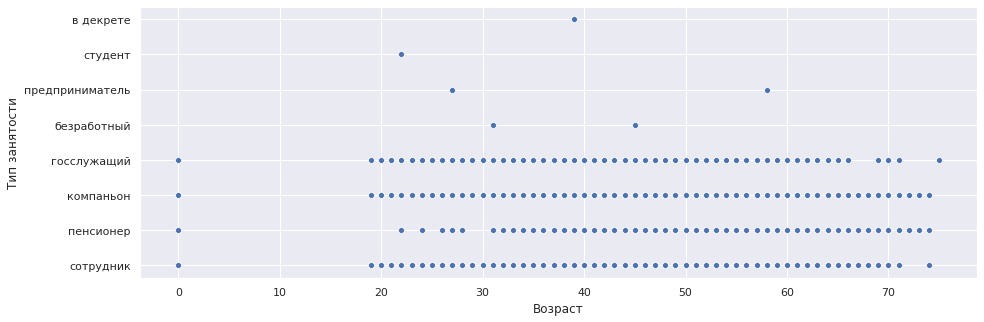

In [21]:
sns.scatterplot(data = df, x = 'dob_years', y ='income_type' ).set(xlabel ='Возраст', ylabel ='Тип занятости');

Из графика видно,что распределение нормальное, за исключением выпадающих точек у сотрудников, пенсионеров, компаньонов и госслужащих, но этих значений минимальное количество. Опять же, заменим их на средний возраст в группе.

In [22]:
#Создадим переменные с медианами зарплат по группам
employee_age = df[df['income_type'] == 'сотрудник']['dob_years'].mean()
companion_age = df[df['income_type'] == 'компаньон']['dob_years'].mean()
pensioner_age = df[df['income_type'] == 'пенсионер']['dob_years'].mean()
civil_age = df[df['income_type'] == 'госслужащий']['dob_years'].mean()



# Заменим пропуски в значениях
df.loc[(df['income_type'] == 'сотрудник') & (df['dob_years'] == 0),'dob_years'] = employee_age
df.loc[(df['income_type'] == 'компаньон') & (df['dob_years'] == 0),'dob_years'] = companion_age
df.loc[(df['income_type'] == 'пенсионер') & (df['dob_years'] == 0),'dob_years'] = pensioner_age
df.loc[(df['income_type'] == 'госслужащий') & (df['dob_years'] == 0),'dob_years'] = civil_age


In [23]:
# Проверка заполнения данных
display(df['dob_years'].describe())

count    21525.00000
mean        43.49822
std         12.22943
min         19.00000
25%         34.00000
50%         43.00000
75%         53.00000
max         75.00000
Name: dob_years, dtype: float64

Теперь, когда данные заполнены, можно начинать обработку дуликатов.

#### **Вывод**

Были заполнены отсутствующие значения в различных столбцах:

- Значения столбца *'children'* поправлено исходя из ошибки считывания данных;	
- Значения столбца *'days_employed'* заполнено по медиане и приведено в года (ошибка осталась,однако....1100 лет стажа - это сильно)
- Столбец *'dob_years'* скорректирован по медиане для групп по типу занятости;
- Единичная ошибка в столбце *'gender'* исправлена по наиболее вероятному варианту;
- Пропущенные значения столбца *'total_income'* дополнены по медиане дохода внутри группы по типу заработка;

### Замена типа данных

Есть ещё одна существенная проблема со столбцом *'total_income'*, а именно тип данных данного столбца (*float*). Для дальнейшей более удобной работы, а так же проведения расчётов требуется привести значения данного столбца к целочисленному виду. Из-за большого разряда целой части каждого значения,округление можно приводить простым отбрасыванием дробной части без потери точности результата. Для данного метода подойдёт метод для серий `.astype(int)`

In [24]:
df['total_income'] = df['total_income'].astype(int)
df['days_employed'] = df['days_employed'].astype(int)

#### **Вывод**

Таким образом,все значения приведены к удобному для дальнейшего использования виду.

### Обработка дубликатов

Для начала исправим столбец *'education'*, приведя все значения к нижнему регистру.

In [25]:
df['education'] = df['education'].str.lower()
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926,27.0,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,2879,43.0,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,152,50.0,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,6929,35.0,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,2188,41.0,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


Далее найдём количество явных дубликатов комбинацией методов `duplicated()` и `sum()`.

In [26]:
df.duplicated().sum()

71

Рассмотрим дубликаты подробнее

In [27]:
df_dupl = df[df.duplicated() == True]
display(df_dupl)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,1360,41.0,среднее,1,женат / замужем,0,F,сотрудник,0,133546,покупка жилья для семьи
3290,0,360505,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,110179,сыграть свадьбу
4182,1,1360,34.0,высшее,0,гражданский брак,1,F,сотрудник,0,133546,свадьба
4851,0,360505,60.0,среднее,1,гражданский брак,1,F,пенсионер,0,110179,свадьба
5557,0,360505,58.0,среднее,1,гражданский брак,1,F,пенсионер,0,110179,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0,360505,64.0,среднее,1,женат / замужем,0,F,пенсионер,0,110179,дополнительное образование
21032,0,360505,60.0,среднее,1,женат / замужем,0,F,пенсионер,0,110179,заняться образованием
21132,0,1360,47.0,среднее,1,женат / замужем,0,F,сотрудник,0,133546,ремонт жилью
21281,1,1360,30.0,высшее,0,женат / замужем,0,F,сотрудник,0,133546,покупка коммерческой недвижимости


Видим, что в датафрейме присутствуют реально дулирующиеся значения, удалим дубликаты.

In [28]:
df_filtered = df.drop_duplicates()
#а так же проверим,остались ли где-то незаполненные значения:
df_filtered.isna().count()

children            21454
days_employed       21454
dob_years           21454
education           21454
education_id        21454
family_status       21454
family_status_id    21454
gender              21454
income_type         21454
debt                21454
total_income        21454
purpose             21454
dtype: int64

Так же можно для большего удобства убрать из  датафрейма столбцы с по сути дублированными значениями, несущими идентичный смысл, предварительно сохранив их в отдельных датафреймах.

In [29]:
sl_educations = df_filtered[['education','education_id']]
sl_family_statuses = df_filtered[['family_status','family_status_id']]
#print(sl_educations.head())
#print(sl_family_statuses.head())

In [30]:
df_filtered = df_filtered.drop(['education_id','family_status_id'],1)
#df_filtered = df_filtered.drop('family_status', 1)
df_filtered.head(10)

,children,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose
0,1,8437,42.0,высшее,женат / замужем,F,сотрудник,0,253875,покупка жилья
1,1,4024,36.0,среднее,женат / замужем,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33.0,среднее,женат / замужем,M,сотрудник,0,145885,покупка жилья
3,3,4124,32.0,среднее,женат / замужем,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53.0,среднее,гражданский брак,F,пенсионер,0,158616,сыграть свадьбу
5,0,926,27.0,высшее,гражданский брак,M,компаньон,0,255763,покупка жилья
6,0,2879,43.0,высшее,женат / замужем,F,компаньон,0,240525,операции с жильем
7,0,152,50.0,среднее,женат / замужем,M,сотрудник,0,135823,образование
8,2,6929,35.0,высшее,гражданский брак,F,сотрудник,0,95856,на проведение свадьбы
9,0,2188,41.0,среднее,женат / замужем,M,сотрудник,0,144425,покупка жилья для семьи


#### **Вывод**

Пробелов в данных не осталось,все стобцы одинаковой длины,нулевых значений нет и мы избавились от дубликатов. Скорее всего дубликаты могли появиться при повторных обращениях клиента в банк в другом возрасте. Однако остаётся ещё столбец *'purpose'* в котором присутствует много однотипных запросов, написанных разных способом. Это можно увидеть методом `unique()`.

In [31]:
purposes = df_filtered['purpose'].unique()
display(purposes)

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

### Лемматизация и категоризация 

Проще всего будет исправить данные в этом столбце используя лемматизацию с использованием функции для создания нового столбца измененных значений, имеющих одинаковый смысл для того, чтобы можно было проводить дальнейшие исследования. 

In [32]:
m = Mystem() 

#Напишем цикл, который пройдет по всему столбцу 'purpose'  и посчитает уникальные значения
lemmas_list =[]
for purpose in purposes:
    lemmas = ' '.join(m.lemmatize(purpose)).strip()
    lemmas_list.append(lemmas)
print(Counter(lemmas_list))

Counter({'автомобиль': 2, 'покупка   жилье': 1, 'приобретение   автомобиль': 1, 'дополнительный   образование': 1, 'сыграть   свадьба': 1, 'операция   с   жилье': 1, 'образование': 1, 'на   проведение   свадьба': 1, 'покупка   жилье   для   семья': 1, 'покупка   недвижимость': 1, 'покупка   коммерческий   недвижимость': 1, 'покупка   жилой   недвижимость': 1, 'строительство   собственный   недвижимость': 1, 'недвижимость': 1, 'строительство   недвижимость': 1, 'на   покупка   подержать   автомобиль': 1, 'на   покупка   свой   автомобиль': 1, 'операция   с   коммерческий   недвижимость': 1, 'строительство   жилой   недвижимость': 1, 'жилье': 1, 'операция   со   свой   недвижимость': 1, 'заниматься   образование': 1, 'сделка   с   подержанный   автомобиль': 1, 'получение   образование': 1, 'свадьба': 1, 'получение   дополнительный   образование': 1, 'покупка   свой   жилье': 1, 'операция   с   недвижимость': 1, 'получение   высокий   образование': 1, 'свой   автомобиль': 1, 'сделка   с  

Как мы видим на основе полученных данных, можно сделать категоризацию именно по данному столбцу.

Чаще всего упоминаются категории "авто", "недвижимость" или "жилье", "свадьба" и "образование". Попробуем сделать функцию для обработки по этим ключевым словам. Если что-то упустили, отработает дополнительное условие и выведет что значение не подошло ни к одному из перечисленных вариантов.

In [33]:
#Cоставим функцию на вход будет подаваться строка из столбца 'purpose'.
#цикл последовательно выполняет проверку на соответствие строки заданным значениям 
#и возвращает одну из выбранных строк-категорий.

def category_purpose(row):
    lemm_purpose = m.lemmatize(row['purpose'])
    if 'автомобиль' in lemm_purpose:
        return 'машина'
    if ('жилье' in lemm_purpose) or ('недвижимость' in lemm_purpose):
        return 'недвижимость'
    if 'образование' in lemm_purpose:
        return 'образование'
    if 'свадьба' in lemm_purpose: 
        return 'свадьба'
    else: 
        return not_mentioned
df_filtered['purpose_category'] = df_filtered.apply(category_purpose, axis = 1)
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926,27.0,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,2879,43.0,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,152,50.0,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,6929,35.0,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,2188,41.0,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


In [34]:
#Заодно проверим, не осталось ли необработанных значений, которые не были лемматизированы

display(df_filtered['purpose_category'].unique())
#и уберем старый столбец с целями кредита
df = df.drop(['purpose'],1)

array(['недвижимость', 'машина', 'образование', 'свадьба'], dtype=object)

**Вывод**

Как мы видим,все замены осуществлены корректно,ошибок в выполнении кода не выявлено. Основными целями для получения кредита, таким образом,являются недвижимость, свадьба, автомобиль и образование какой-то значимой корреляции между целью кредита и другими данными выявить проблематично,но для рассчёта скоринга этого уже вполне достаточно. По этим данным мы и будем в дельнейшем категоризировать данный датафрейм.

### Категоризация данных

Сначала посчитаем, сколько клиентов, желающих взять кредит в каждой из групп, сформированных по цели кредита, имеют задолженность.

In [35]:
# Узнаем, сколько в каждой из групп людей с задолженностями по кредитам

df_filtered[df_filtered['debt'] == 1].groupby('purpose_category')['debt'].count().sort_values(ascending = False)

purpose_category
недвижимость    782
машина          403
образование     370
свадьба         186
Name: debt, dtype: int64

In [36]:
#создадим фукцию,которая создаст новую серию на основе столбца 'debt'
def debt_status(debt):
    if debt == 0:
        return 'нет задолженности'
    if debt == 1:
        return 'задолженность'   
    #применим функцию и удалим столбец 'debt'
df_filtered['debt_status'] = df_filtered['debt'].apply(debt_status)


def children_status(children):
    if children > 0:
        return 'есть дети'
    else:
        return 'детей нет'   
    #применим функцию и удалим столбцы 'debt' и 'children'
df_filtered ['children_status'] = df_filtered['children'].apply(children_status)
#df_filtered.drop(['debt'],axis = 1, inplace = True)
df_filtered.drop(['children'],axis = 1, inplace = True)
df_filtered.head(15)

,days_employed,dob_years,education,family_status,gender,income_type,debt,total_income,purpose,purpose_category,debt_status,children_status
0,8437,42.0,высшее,женат / замужем,F,сотрудник,0,253875,покупка жилья,недвижимость,нет задолженности,есть дети
1,4024,36.0,среднее,женат / замужем,F,сотрудник,0,112080,приобретение автомобиля,машина,нет задолженности,есть дети
2,5623,33.0,среднее,женат / замужем,M,сотрудник,0,145885,покупка жилья,недвижимость,нет задолженности,детей нет
3,4124,32.0,среднее,женат / замужем,M,сотрудник,0,267628,дополнительное образование,образование,нет задолженности,есть дети
4,340266,53.0,среднее,гражданский брак,F,пенсионер,0,158616,сыграть свадьбу,свадьба,нет задолженности,детей нет
5,926,27.0,высшее,гражданский брак,M,компаньон,0,255763,покупка жилья,недвижимость,нет задолженности,детей нет
6,2879,43.0,высшее,женат / замужем,F,компаньон,0,240525,операции с жильем,недвижимость,нет задолженности,детей нет
7,152,50.0,среднее,женат / замужем,M,сотрудник,0,135823,образование,образование,нет задолженности,детей нет
8,6929,35.0,высшее,гражданский брак,F,сотрудник,0,95856,на проведение свадьбы,свадьба,нет задолженности,есть дети
9,2188,41.0,среднее,женат / замужем,M,сотрудник,0,144425,покупка жилья для семьи,недвижимость,нет задолженности,детей нет


Так же для того чтобы в дальнейшем сделать вывод о зависимости между уровнем дохода и возвращением кредита в срок, следует сначала определить уровни доходов клиентов. Для этого можно воспользоваться категориями [Росстата](https://zavtra.ru/blogs/eto_interesno_i_polezno_znat_),согласно которому население делится по доходам на 5 классов:

1) Нищие – душевой доход **до 1** ПМ/чел;

2) Бедные - душевой доход **от 1 до 3** ПМ/чел;

3) Выше бедности - доход **от 3 до 7** ПМ/чел;

4) Средний класс – доход **от 7 до 11** ПМ/чел;

5) Высший класс (богатые и сверхбогатые) – доход **более 11** ПМ/чел.

Где **ПМ** - величина прожиточного минимума, которая на текущий год составляет [18 029 рублей](https://www.interfax.ru/moscow/797225)

Таким образом составим новый столбец исходя из данных о доходе клиентов и статистической информации.

In [37]:
pm = 18029
#создадим фукцию,которая создаст новую серию на основе столбца 'total_income'
def income_status(row):
    if row['total_income'] < pm:
        return 'нищий'
    if pm <= row['total_income'] < 3*pm  :
        return 'бедный'
    if 3*pm <= row['total_income'] < 7*pm  :
        return 'ниже среднего'
    if 7*pm <= row['total_income'] < 11*pm  :
        return 'средний'
    if row['total_income'] >= 11*pm  :
        return 'высокий достаток'
    #применим функцию и удалим столбец 'total_income'
df_filtered ['income_status'] = df_filtered.apply(income_status, axis = 1)
df_filtered.drop(['total_income'],axis = 1, inplace = True)


Так же для улучшения читаемости отбросим столбцы *'days_employed'* и *'dob_years'*, сохранив их в отдельную переменную, если вдруг где-то понадобится.

In [38]:
job_time = df_filtered[['days_employed','dob_years']]
df_filtered.drop(['days_employed'],axis = 1, inplace = True)
df_filtered.drop(['dob_years'],axis = 1, inplace = True)
# Посмотрим, что получилось
df_filtered.head()
#job_time.head()

,education,family_status,gender,income_type,debt,purpose,purpose_category,debt_status,children_status,income_status
0,высшее,женат / замужем,F,сотрудник,0,покупка жилья,недвижимость,нет задолженности,есть дети,высокий достаток
1,среднее,женат / замужем,F,сотрудник,0,приобретение автомобиля,машина,нет задолженности,есть дети,ниже среднего
2,среднее,женат / замужем,M,сотрудник,0,покупка жилья,недвижимость,нет задолженности,детей нет,средний
3,среднее,женат / замужем,M,сотрудник,0,дополнительное образование,образование,нет задолженности,есть дети,высокий достаток
4,среднее,гражданский брак,F,пенсионер,0,сыграть свадьбу,свадьба,нет задолженности,детей нет,средний


#### **Вывод**

- Мы лемматизировали столбец целей кредита, определили нужные и добавили в датафрейм в виде отдельного столбца;
- Создали категоризацию по уровню дохода, разделив людей на 5 групп;
- Касательно семейного статуса, считаю, что дополнительная категоризация не нужна, эта представляется наиболее диверсифицированной и при этом точной. Можно было бы объединить категории женат/замужем и гражданский брак, а так же не женат/не замужем и вдова/вдовец. Но замужние и женатые могут быть больше связаны юридически, например другими кредитами (супруг или супруга заявителя), которые по законодательству будут являться родственниками,обязанными выплачивать кредит. В то время как гражданский брак не имеет такой юридической подоплёки и кредитная ситуация сожителя может быть не отражена.  Так же сложно судить о прямой взаимосвязи людей неженатых/незамужних и вдов/вдовцов, хотя логически они ближе всего друг к другу. Не объединяю их с разведенными, так как у разведенных людей могут быть алименты, дети как рожденные в семье(которые могут иметь долю в наследстве и при разделе имущества), так и вне семьи (что может не отражаться в заявлении). Слишком много различных нюансов,которые могут прямо или косвенно влиять на метрику, из-за этого полагаю, пусть лучше остаются в разных категориях;


## Шаг 3. Ответьте на вопросы

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [39]:
table_children = df_filtered.pivot_table(
index = 'debt_status',
columns = ['children_status'],
values = 'debt',
aggfunc = 'count')
pcnt = '{:.2%}'.format
table_children.loc['доля'] = (table_children.iloc[0]/(table_children.iloc[1]+table_children.iloc[0])).map(pcnt)
display(table_children.sort_index(ascending = False))

children_status,детей нет,есть дети
debt_status,,
нет задолженности,13028,6685
задолженность,1063,678
доля,7.54%,9.21%


####  **Промежуточный вывод**

Исходя из полученной таблицы,можно сделать следующие выводы:
- Клиенты, у которых есть дети, в два раза реже берут кредиты;
- Клиенты с детьми чаще  имеют задолженность по кредитам.

Первый факт может быть обоснован тем, что содержание ребенка реже позволяет взять на себя дополнительную статью расходов в виде оплаты кредита.
С другой стороны, семейные люди, у которых есть дети, являются менее надежными и платежеспособными клиентами, поскольку больше подвержены рискам,связанным с вынужденными незапланированными тратами на детей.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [40]:
table_family = df_filtered.pivot_table(
index = 'debt_status',
columns = ['family_status'],
values = 'debt',
aggfunc = 'count')
pcnt = '{:.2%}'.format
table_family.loc['доля'] = (table_family.iloc[0]/(table_family.iloc[1]+table_family.iloc[0])).map(pcnt)
display(table_family.sort_index(ascending = False))

family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
debt_status,,,,,
нет задолженности,2536,1110,896,3763,11408
задолженность,274,85,63,388,931
доля,9.75%,7.11%,6.57%,9.35%,7.55%


#### **Промежуточный вывод**

Из данной таблицы можно выявить следующее:
- Чаще всего за кредитом обращаются *замужние и женатые* клиенты, а реже всего - *овдовевшие и люди в разводе*, последние к тому же имеют самую низкую долю невозвратов по кредиту;
- Доля людей, имеющих задолженность по кредитам выше в группе *не женат / не замужем* и проживающих в *гражданском браке*;
- Посередине между этими двумя группами находятся люди в группе *женат / замужем*,из них кредитную задолженность имеют 7,5%.

На самом деле если бы мы получили больше данных по группам *в разводе* и *вдовец / вдова*, результаты могли бы отличаться, так как их количество, например, в десять раз ниже количества замужних. Тогда выборка была бы более репрезентативна.
Тем не менее, процент невозвратов кредита вовремя **ниже у двух групп:  в разводе, вдовец / вдова**

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Теперь можно непосредственно посмотреть, как влияет уровень дохода на платежеспособность.

In [41]:
table_income = df_filtered.pivot_table(
index = 'debt_status',
columns = ['income_status'],
values = 'debt',
aggfunc = 'count')
pcnt = '{:.2%}'.format
table_income.loc['доля'] = (table_income.iloc[0]/(table_income.iloc[1]+table_income.iloc[0])).map(pcnt)
display(table_income.sort_index(ascending = False))

income_status,бедный,высокий достаток,ниже среднего,нищий,средний
debt_status,,,,,
нет задолженности,496,4811,6729,139,7538
задолженность,34,365,622,7,713
доля,6.42%,7.05%,8.46%,4.79%,8.64%


#### **Промежуточный вывод**

- Люди, которые находятся в тяжелом материальном положении, имеют при этом более низкий процент невозвратов;
- Довольно низкий процент невозвратов так же у людей с высоким достатком;
- Люди, имеющие средний (и немного ниже среднего) достаток, имеют больше задолженностей по кредитам;
- Чаще всего берут кредит люди со средним достатком или достатком ниже среднего;

Низкий процент невозвратов у людей с низким достатком может быть связан с тем, что суммы могут браться "до зарплаты" и возможно чаще суммы кредитов меньше. Так же стоить заметить, что их доля среди всех заемщиков крайне мала.

### Как разные цели кредита влияют на его возврат в срок?

In [42]:
table_purpose = df_filtered.pivot_table(
index = 'debt_status',
columns = ['purpose_category'],
values = 'debt',
aggfunc = 'count')
pcnt = '{:.2%}'.format
table_purpose.loc['доля'] = (table_purpose.iloc[0]/(table_purpose.iloc[1]+table_purpose.iloc[0])).map(pcnt)
display(table_purpose.sort_index(ascending = False))

purpose_category,машина,недвижимость,образование,свадьба
debt_status,,,,
нет задолженности,3903,10029,3643,2138
задолженность,403,782,370,186
доля,9.36%,7.23%,9.22%,8.00%


#### **Промежуточный вывод**

- Самые низкие проценты по категориям целей кредитов являются *покупка недвижимости* и *свадьба*
- Кредиты,которые были взяты для *покупки автомобиля* и на *образование* клиенты возвращают хуже

Это может быть связано с тем, что кредиты, взятые для проведения свадьбы могут возвращаться лучше из-за подарков деньгами молодоженам, которыми и закрывается основная сумма кредита или кредит полностью.
Чаще всего кредит для покупки недвижимости берут люди,уверенные в своем финансовом положении,так что чаще их материальное состояние является более стабильным. Так же многие покупают недвижимость для дальнейшей сдачи в аренду и могут оплачивать кредит деньгами с ренты. К тому же, другая часть часто уже въезжает в купленную недвижимость,если она взята например на вторичном рынке и поскольку сделка формально проводится через банк,до выплаты кредита банк часто является собственником до выплаты кредита и в случае неуплаты квартира может быть изъята банком для погашения кредита и пени за просрочку платежа и процентов.
Покупка автомобиля, как потенциально опасного средства перемещения, может быть омрачена высоким риском попадания человека в [ДТП](http://stat.gibdd.ru/) и при отсутствии необязательной страховки, оплата ремонта машин участников ДТП может лечь на человека,взявшего кредит на машину, что будет негативно сказываться на его платежеспособности. 

## Шаг 4. Общий вывод

В целом все проверенные факторы являются относительно релевантыми для проверки человека, который хочет получить кредит в большей или меньшей степени.
Категориально стоит обратить особое внимание на достаток, семейное положение и наличие детей.
Порядок влияния всех исследованных факторов находится примерно на одном уровне.

### Наиболее надежные клиенты по группам
- Самые надежные в группе по *наличию детей* являются клиенты **без детей**;
- Самыми надежными в группе по *семейному положению* являются люди **в разводе** и **вдовцы / вдовы**;
- В группе по *уровню достатка* - люди **с низким доходом,бедные, нищие** и **богатые**;
- Самые надежные *цели* для кредита - **покупка недвижимости** и **свадьба**.

### Наименее надежные клиенты по группам
- Самыми ненадежными в группе по *наличию детей* являются клиенты **с детьми**;
- Самыми надежными в группе по *семейному положению* являются люди **в гражданском браке** и **не женатые /не замужем**;
- В группе по *уровню достатка* - люди **доходом ниже среднего** и **средним**,они же самая большая группа выборки;
- Самые рискованные *цели* для кредита - **покупка автомобиля** и **образование**.
 